# **Proyek Klasifikasi Gambar IDCamp 2024: Car Vs Bike**


*   Nama: Kirana Alyssa Putri
*   Email: kiranaalyssa.putri@gmail.com







## Import Semua Packages/Library yang Digunakan

In [ ]:
# Import Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [ ]:
# Import Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Import Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kiranaalyssaputri","key":"e267b0aa42023f3c8fe0f2793dad732b"}'}

In [ ]:
# Download kaggle dataset and unzip the file
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset
!unzip car-vs-bike-classification-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
 96% 99.0M/103M [00:04<00:00, 37.1MB/s]
100% 103M/103M [00:04<00:00, 25.1MB/s] 
Archive:  car-vs-bike-classification-dataset.zip
  inflating: Car-Bike-Dataset/Bike/Bike (1).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (1).png  
  inflating: Car-Bike-Dataset/Bike/Bike (10).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (10).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (10).png  
  inflating: Car-Bike-Dataset/Bike/Bike (100).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (100).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (1000).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1001).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1002).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1003).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1004).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1005).jpeg  
  inflating: Car-Bike

### Data Pre-processing

In [ ]:
# Direktori asal yang berisi dataset asli (berisi folder 'car' dan 'bike')
source_dir = "Car-Bike-Dataset"

# Direktori untuk menyimpan dataset yang sudah dipisahkan menjadi train dan test
train_dir = "car_vs_bike/train"
test_dir = "car_vs_bike/test"

# Direktori gabungan untuk menyimpan dataset sebelum dipisahkan menjadi train/test
combined_dir = "car_vs_bike/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk membuat direktori jika belum ada
def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

# MemBuat direktori train dan test jika belum ada
create_dir_if_not_exists(train_dir)
create_dir_if_not_exists(test_dir)

# Fungsi untuk memindahkan gambar dari source ke target
def move_images(source, target):
    if not os.path.exists(source):
        print(f"Error: Directory {source} does not exist")
        return

    for category in os.listdir(source):
        category_dir = os.path.join(source, category)
        if os.path.isdir(category_dir):
            target_dir = os.path.join(target, category)
            create_dir_if_not_exists(target_dir)
            for image in os.listdir(category_dir):
                shutil.copy(os.path.join(category_dir, image), target_dir)
        else:
            print(f"{category_dir} is not a directory")

# Pindahkan gambar dari source ke train dan test (anda bisa mengatur sesuai kebutuhan)
move_images(source_dir, combined_dir)

print("Gambar berhasil dipindahkan ke direktori gabungan.")

Created directory: car_vs_bike/train
Created directory: car_vs_bike/test
Created directory: car_vs_bike/dataset/Car
Created directory: car_vs_bike/dataset/Bike
Gambar berhasil dipindahkan ke direktori gabungan.


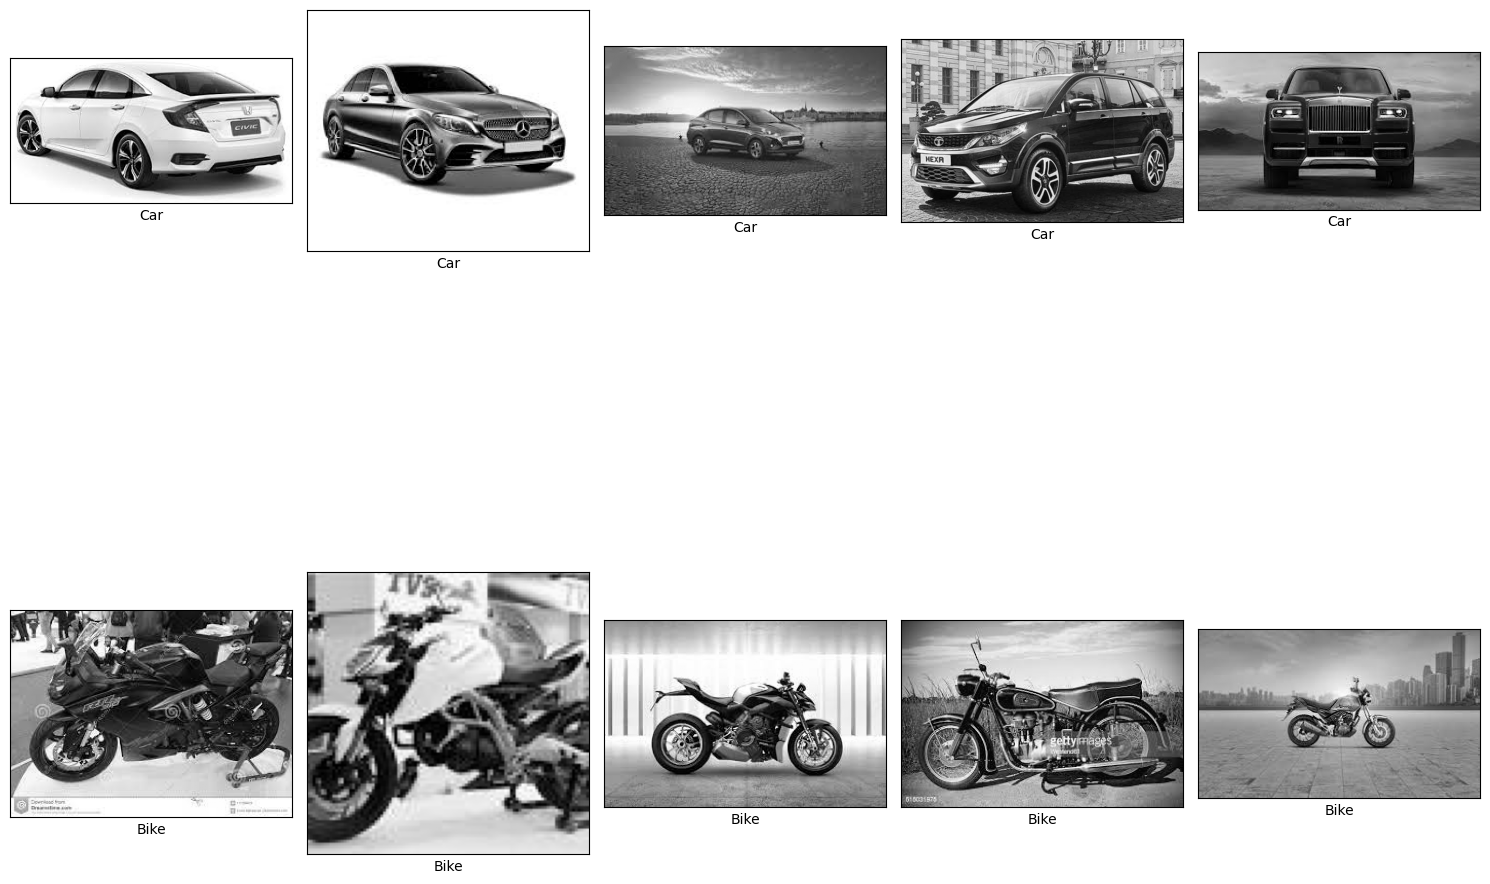

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
car_bike_image = {}

# Tentukan path sumber train
path = "car_vs_bike/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    car_bike_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "car_vs_bike/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(car_bike_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(car_bike_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

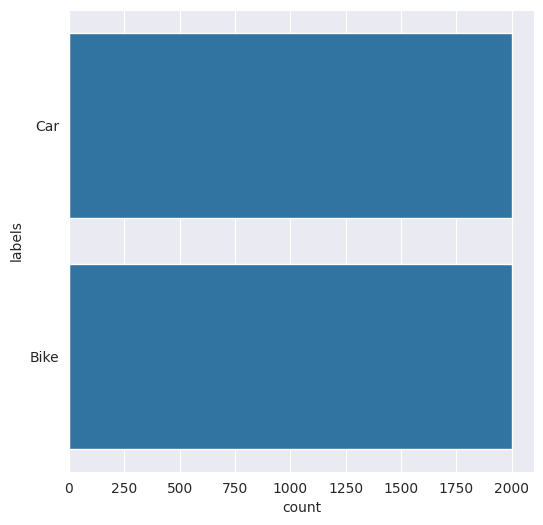

In [ ]:
# Definisikan path sumber
car_bike_path = "car_vs_bike/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(car_bike_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Mengecek apakah gambar memiliki mode P atau RGBA yang akan menyebabkan eror
dataset_dirs = ["car_vs_bike/dataset/Car", "car_vs_bike/dataset/Bike"]

for dataset_dir in dataset_dirs:
    for filename in os.listdir(dataset_dir):
        file_path = os.path.join(dataset_dir, filename)
        try:
            img = Image.open(file_path)
            if img.mode not in ["RGB", "L"]:  # RGB untuk warna, L untuk grayscale
                print(f"Image {file_path} has mode {img.mode} and may cause issues.")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

Image car_vs_bike/dataset/Car/Car (6).png has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Car/Car (2).png has mode P and may cause issues.
Image car_vs_bike/dataset/Car/Car (7).png has mode P and may cause issues.
Image car_vs_bike/dataset/Car/Car (1).png has mode P and may cause issues.
Image car_vs_bike/dataset/Car/Car (3).png has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (93).jpg has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (3).png has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (18).png has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (22).png has mode P and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (23).png has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (4).png has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (11).png has mode RGBA and may cause issues.
Image car_vs_bike/dataset/Bike/Bike (25).png has mode RGB

In [ ]:
# Konversi Gambar ke RGB
dataset_dirs = ["car_vs_bike/dataset/Car", "car_vs_bike/dataset/Bike"]

for dataset_dir in dataset_dirs:
    for filename in os.listdir(dataset_dir):
        file_path = os.path.join(dataset_dir, filename)
        try:
            img = Image.open(file_path)

            # Jika mode P dan memiliki transparansi, ubah ke RGBA dulu
            if img.mode == "P":
                img = img.convert("RGBA")

            # Jika mode RGBA atau P, ubah ke RGB
            if img.mode in ["P", "RGBA"]:
                img = img.convert("RGB")
                img.save(file_path)  # Simpan ulang dengan format yang benar
                print(f"Fixed: {file_path}")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

Fixed: car_vs_bike/dataset/Car/Car (6).png
Fixed: car_vs_bike/dataset/Car/Car (2).png
Fixed: car_vs_bike/dataset/Car/Car (7).png
Fixed: car_vs_bike/dataset/Car/Car (1).png
Fixed: car_vs_bike/dataset/Car/Car (3).png
Fixed: car_vs_bike/dataset/Bike/Bike (93).jpg
Fixed: car_vs_bike/dataset/Bike/Bike (3).png
Fixed: car_vs_bike/dataset/Bike/Bike (18).png
Fixed: car_vs_bike/dataset/Bike/Bike (22).png
Fixed: car_vs_bike/dataset/Bike/Bike (23).png
Fixed: car_vs_bike/dataset/Bike/Bike (4).png
Fixed: car_vs_bike/dataset/Bike/Bike (11).png
Fixed: car_vs_bike/dataset/Bike/Bike (25).png
Fixed: car_vs_bike/dataset/Bike/Bike (24).png
Fixed: car_vs_bike/dataset/Bike/Bike (1).png
Fixed: car_vs_bike/dataset/Bike/Bike (41).jpg
Fixed: car_vs_bike/dataset/Bike/Bike (8).png
Fixed: car_vs_bike/dataset/Bike/Bike (6).png
Fixed: car_vs_bike/dataset/Bike/Bike (20).png
Fixed: car_vs_bike/dataset/Bike/Bike (18).jpg
Fixed: car_vs_bike/dataset/Bike/Bike (5).png
Fixed: car_vs_bike/dataset/Bike/Bike (27).png
Fixed: ca

### Data Splitting

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'car_vs_bike/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Bike,2000
Car,2000


In [ ]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "car_vs_bike/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels
test   Bike       387
       Car        413
train  Bike      1613
       Car       1587
dtype: int64 


                                            path labels    set
957      car_vs_bike/dataset/Bike/Bike (124).jpg   Bike  train
1679  car_vs_bike/dataset/Bike/images (148).jpeg   Bike  train
2140    car_vs_bike/dataset/Bike/Bike (895).jpeg   Bike  train
161    car_vs_bike/dataset/Bike/Bike (1265).jpeg   Bike  train
409     car_vs_bike/dataset/Bike/Bike (833).jpeg   Bike  train


In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_car = os.path.join(TRAIN_DIR + 'Car')
train_bike = os.path.join(TRAIN_DIR + 'Bike')
test_car = os.path.join(TEST_DIR + 'Car')
test_bike = os.path.join(TEST_DIR + 'Bike')

print("Total number of car images in training set: ",len(os.listdir(train_car)))
print("Total number of bike images in training set: ",len(os.listdir(train_bike)))
print("Total number of car images in test set: ",len(os.listdir(test_car)))
print("Total number of bike images in test set: ",len(os.listdir(test_bike)))

Total number of car images in training set:  1587
Total number of bike images in training set:  1613
Total number of car images in test set:  413
Total number of bike images in test set:  387


In [ ]:
# Buat objek ImageDataGenerator untuk training dengan augmentasi data
datagen = ImageDataGenerator( rescale=1/255.,          # Normalisasi pixel
                              rotation_range=20,       # Rotasi acak hingga 20 derajat
                              width_shift_range=0.2,   # Pergeseran lebar gambar hingga 20%
                              height_shift_range=0.2,  # Pergeseran tinggi gambar hingga 20%
                              shear_range=0.2,         # Transformasi shearing
                              zoom_range=0.2,          # Zoom in dan out hingga 20%
                              horizontal_flip=True,    # Membalik gambar secara horizontal
                              fill_mode='nearest',     # Mengisi piksel kosong setelah transformasi
                              validation_split=0.2)    # Memisahkan 20% data untuk validasi

# Data generator untuk validasi & testing (tanpa augmentasi, hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Train generator dengan augmentasi
train_generator = datagen.flow_from_directory(  TRAIN_DIR,
                                                classes=['Car', 'Bike'],
                                                batch_size=32,
                                                target_size=(150,150),
                                                color_mode="grayscale",
                                                class_mode='binary',
                                                subset='training',
                                                shuffle=True)

# Validation generator (tanpa augmentasi)
validation_generator = datagen.flow_from_directory( TRAIN_DIR,
                                                    classes=['Car', 'Bike'],
                                                    batch_size=32,
                                                    target_size=(150,150),
                                                    color_mode="grayscale",
                                                    class_mode='binary',
                                                    subset='validation',
                                                    shuffle=False)

# Test generator (tanpa augmentasi)
test_generator = test_datagen.flow_from_directory(  TEST_DIR,
                                                    classes=['Car', 'Bike'],
                                                    batch_size=1,
                                                    target_size=(150,150),
                                                    color_mode="grayscale",
                                                    class_mode='binary',
                                                    shuffle=False)

Found 2561 images belonging to 2 classes.
Found 639 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Modelling

In [ ]:
# Membersihkan sesi TensorFlow sebelumnya untuk menghindari konflik model
tf.keras.backend.clear_session()

# Inisialisasi Model Sequential
model_1 = Sequential()

# Lapisan Input dengan Lapisan Fully Connected
# Lapisan konvolusi pertama, normalisasi batch, dan lapisan pooling
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())  # Menormalkan output dari lapisan konvolusi sebelumnya
model_1.add(MaxPool2D((2, 2)))  # Mengurangi dimensi fitur untuk menghindari overfitting

# Lapisan konvolusi kedua, normalisasi batch, dan lapisan pooling
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Lapisan konvolusi ketiga, normalisasi batch, dan lapisan pooling
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Lapisan Flatten (mengubah hasil konvolusi menjadi bentuk vektor)
model_1.add(Flatten())

# Lapisan Dense pertama (Fully Connected)
model_1.add(Dense(128, activation='relu'))

# Lapisan Dropout pertama (mengurangi overfitting dengan mengabaikan sebagian neuron selama training)
model_1.add(Dropout(0.5))

# Lapisan Dense kedua
model_1.add(Dense(64, activation='relu'))

# Lapisan Dropout kedua
model_1.add(Dropout(0.3))

# Lapisan output (kelas biner, menggunakan aktivasi sigmoid)
model_1.add(Dense(1, activation='sigmoid'))

# Kompilasi Model
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss='binary_crossentropy',  # Menggunakan binary cross-entropy karena klasifikasi biner
                metrics=['accuracy'])  # Menggunakan metrik akurasi untuk evaluasi

# Menampilkan ringkasan arsitektur model
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


## Evaluasi dan Visualisasi

In [ ]:
# Callbacks
# Simpan model terbaik berdasarkan val_loss
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', save_weights_only=False)

# Hentikan training jika val_loss tidak membaik dalam 10 epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Kurangi learning rate jika val_loss stagnan selama 5 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

count_car, count_bike = len(os.listdir(train_car)), len(os.listdir(train_bike))
weight_0 = (1 / count_car) * (count_car + count_bike) / 2.0
weight_1 = (1 / count_bike) * (count_bike + count_car) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[early_stopping, checkpoint, reduce_lr])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.5542 - loss: 0.8526 - val_accuracy: 0.4961 - val_loss: 0.7718 - learning_rate: 1.0000e-04
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6261 - loss: 0.6854 - val_accuracy: 0.4961 - val_loss: 0.9086 - learning_rate: 1.0000e-04
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.7142 - loss: 0.5817 - val_accuracy: 0.6980 - val_loss: 0.6183 - learning_rate: 1.0000e-04
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.7590 - loss: 0.4992 - val_accuracy: 0.6275 - val_loss: 0.6337 - learning_rate: 1.0000e-04
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7734 - loss: 0.4907 - val_accuracy: 0.6948 - val_loss: 0.5474 - learning_rate: 1.0000e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7816 - loss: 0.4698 - val_accuracy: 0.7793 - val_loss: 0.4702 - learning_rate: 1.0000e-04
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.8127 

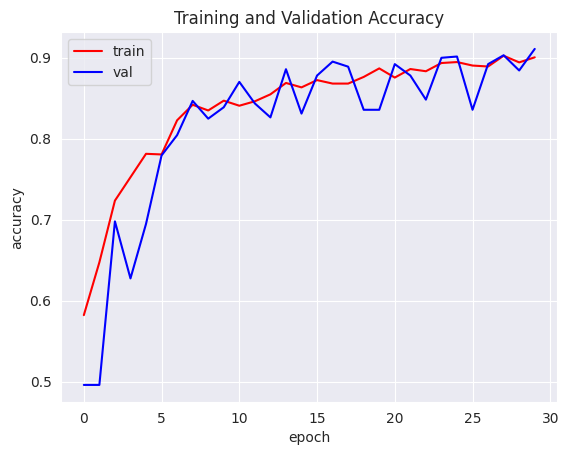

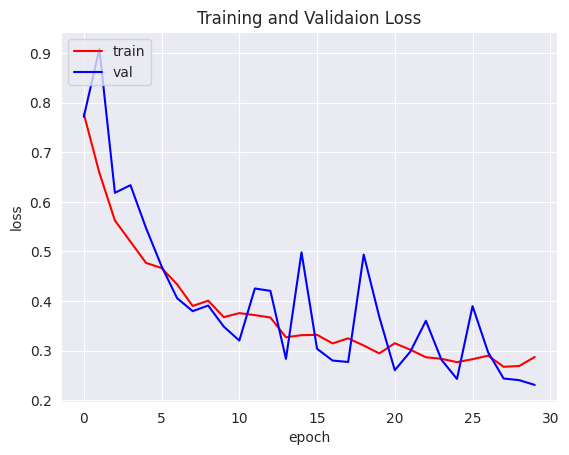

In [ ]:
# Plot Training Validation Accuracy dan Loss
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

         Car     0.9256    0.9637    0.9442       413
        Bike     0.9595    0.9173    0.9379       387

    accuracy                         0.9413       800
   macro avg     0.9425    0.9405    0.9411       800
weighted avg     0.9420    0.9413    0.9412       800



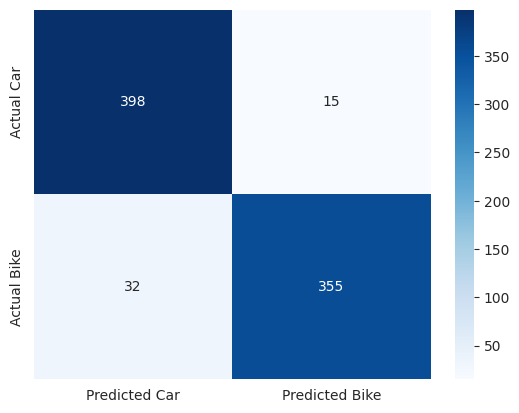

In [ ]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Car", "Actual Bike"],
columns=["Predicted Car", "Predicted Bike"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Car','Bike'], digits=4))

Saving Car.jpeg to Car.jpeg


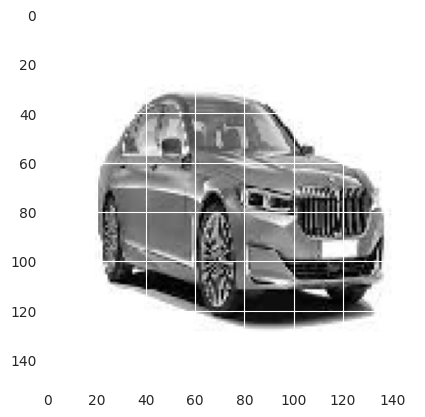

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Car.jpeg
This is a CAR


In [ ]:
# Klasifikasi Gambar Car VS bike
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
    # Memuat gambar
    path = fn
    img = image.load_img(path, target_size=(150, 150), color_mode='grayscale')

    plt.imshow(img, cmap='gray')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    # Mendapatkan probabilitas kelas
    proba = model_1.predict(images, batch_size=10)[0]

    print(fn)
    if proba[0] > 0.5:
        print('This is a CAR')
    else:
        print('This is a BIKE')

## Konversi Model

In [ ]:
# Menyimpan model dalam format SavedModel
import tensorflow as tf
import pathlib

saved_model_dir = 'saved_model'
tf.saved_model.save(model_1, saved_model_dir)
print(f"Model saved to {saved_model_dir}")

Model saved to saved_model


In [ ]:
# Konversi SavedModel menjadi TF-JS
!pip install tensorflowjs

import tensorflow as tf
from tensorflow import keras
import pathlib

# Direktori dari SavedModel
saved_model_dir = 'saved_model/my_model'

# Simpan model dalam format SavedModel
tf.saved_model.save(model_1, saved_model_dir)

# Direktori untuk menyimpan model TensorFlow.js
tfjs_model_dir = 'tfjs_model'
pathlib.Path(tfjs_model_dir).mkdir(parents=True, exist_ok=True)

# Jalankan konversi TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --saved_model_tags=serve {saved_model_dir} {tfjs_model_dir}
print(f"TensorFlow.js model saved to {tfjs_model_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 23.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
2025-02-26 09:50:38.066710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740563438.113292   27836 cuda_dnn.cc:8310] Unable to regis

In [ ]:
# Konversi SavedModel menjadi TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Menyimpan model TF-Lite
tflite_model_dir = 'tflite'
pathlib.Path(tflite_model_dir).mkdir(parents=True, exist_ok=True)
tflite_model_path = pathlib.Path(tflite_model_dir) / 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"TF-Lite model saved to {tflite_model_path}")

with open(pathlib.Path(tflite_model_dir) / 'label.txt', 'w') as f:
    f.write('Car\nBike')
print("Labels saved to label.txt")

TF-Lite model saved to tflite/model.tflite
Labels saved to label.txt


## Requirements.txt

In [ ]:
!pip freeze > requirements.txt

## Saved Model

In [ ]:
# Download saved_model files
from google.colab import files
files.download('saved_model/my_model/variables/variables.data-00000-of-00001')
files.download('saved_model/my_model/variables/variables.index')
files.download('saved_model/my_model/saved_model.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download tfjs_model files
files.download('tfjs_model/model.json')
files.download('tfjs_model/group1-shard1of2.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download tflite files
files.download('tflite/label.txt')
files.download('tflite/model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download requirements.txt
files.download('/content/requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%writefile README.md
# Final Task Dicoding IDCamp 2024 - Klasifikasi Gambar

## Deskripsi
Model ini menggunakan Convolutional Neural Network (CNN) untuk mengklasifikasikan gambar mobil dan motor dengan akurasi tinggi. Dataset yang digunakan terdiri dari 4.000 gambar, dengan 2.000 gambar mobil (Car) dan 2.000 gambar motor (Bike).

## Teknologi yang Digunakan
- Python
- TensorFlow / Keras
- Google Colab

Writing README.md


In [ ]:
from google.colab import files
files.download("README.md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>